In [ ]:
# Reading In all Data from the Folder
import os
import pandas as pd
import seaborn as sns
folder_path = '/content/drive/MyDrive/DeepLearning'
# List to store individual DataFrames
dfs = []
# Loop through all files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.csv'):
        file_path = os.path.join(folder_path, filename)

        # Read the CSV file into a DataFrame
        df = pd.read_csv(file_path)

        # Append the DataFrame to the list
        dfs.append(df)
# Concatenate the list of DataFrames into a single DataFrame
df = pd.concat(dfs, ignore_index=True)
df.to_csv('combined_df.csv',index=False)
df.head(3)

,experiment,Four_1,Four_2,Four_3,Four_4,Four_5,Four_6,Four_7,Four_8,Four_9,...,Four_296,Four_297,Four_298,Four_299,Four_300,Four_301,Four_302,Four_303,Four_304,class
0,Patient_1_MCI,-11.828,21.879,28.383,32.898,18.059,-16.711,-0.297,20.484,28.359,...,-20.755,-7.354,-1.722,-15.935,-18.837,-28.667,-8.921,-14.117,-16.937,MCI
1,Patient_10_MCI,-16.059,-7.656,-0.082,-25.336,13.855,-42.398,-96.215,-0.234,-24.773,...,4.770,13.624,7.439,8.506,15.545,15.997,18.336,15.296,20.068,MCI
2,Patient_11_MCI,-14.574,18.172,3.133,-93.152,-47.086,58.840,46.547,73.609,142.719,...,-20.511,-3.866,-0.091,6.183,-5.907,-13.326,-10.178,6.870,-11.449,MCI


Fold 1/5
Epoch 1/5
9/9 [==============================] - 2s 44ms/step - loss: 21.3625 - accuracy: 0.3870 - val_loss: 7.8145 - val_accuracy: 0.5000
Epoch 2/5
9/9 [==============================] - 0s 11ms/step - loss: 2.9581 - accuracy: 0.6284 - val_loss: 1.0935 - val_accuracy: 0.6667
Epoch 3/5
9/9 [==============================] - 0s 11ms/step - loss: 0.8609 - accuracy: 0.7893 - val_loss: 0.5907 - val_accuracy: 0.7879
Epoch 4/5
9/9 [==============================] - 0s 9ms/step - loss: 0.2559 - accuracy: 0.9157 - val_loss: 0.3527 - val_accuracy: 0.8485
Epoch 5/5
9/9 [==============================] - 0s 9ms/step - loss: 0.1026 - accuracy: 0.9579 - val_loss: 0.1680 - val_accuracy: 0.9545
Fold 2/5
Epoch 1/5
9/9 [==============================] - 2s 38ms/step - loss: 13.3195 - accuracy: 0.3678 - val_loss: 25.7734 - val_accuracy: 0.5455
Epoch 2/5
9/9 [==============================] - 0s 10ms/step - loss: 8.7074 - accuracy: 0.6360 - val_loss: 2.8504 - val_accuracy: 0.5758
Epoch 3/5
9/9 [

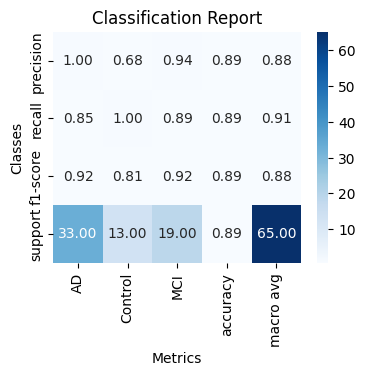

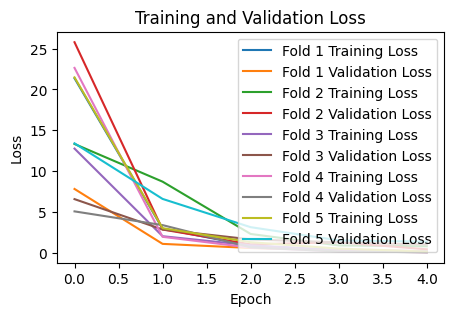

<Figure size 640x480 with 0 Axes>

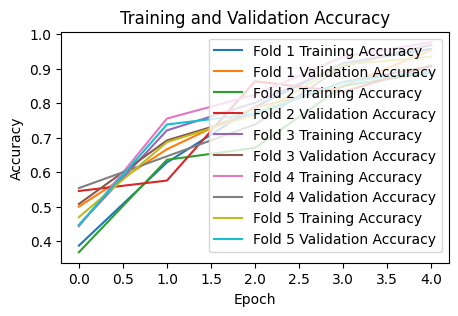

<Figure size 640x480 with 0 Axes>

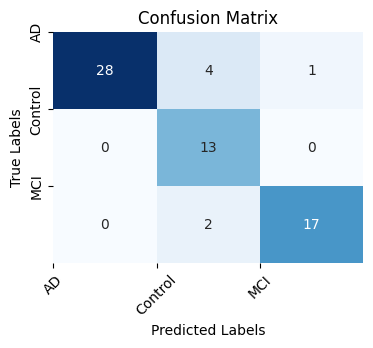

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report,confusion_matrix
import tensorflow as tf
from sklearn.model_selection import KFold
from matplotlib import pyplot as plt

# Define a class to handle data processing
class DataProcessor:
    def __init__(self, seed=42):
        self.seed = seed
        np.random.seed(seed)
        tf.random.set_seed(seed)

    # Load and preprocess data from a given path
    def load_and_preprocess_data(self, data_path):
        df = pd.read_csv(data_path)
        df['label'] = df['experiment'].apply(lambda x: x.split('_')[2])
        df.drop('experiment', axis=1, inplace=True)

        label_encoder = LabelEncoder()
        df["class"] = label_encoder.fit_transform(df["class"])
        df["encoded_label"] = label_encoder.fit_transform(df["label"])

        X = df.drop(["label", "encoded_label"], axis=1)
        y = df["encoded_label"]

        X_tensor = tf.convert_to_tensor(X.values, dtype=tf.float32)
        y_array = y.values

        return X_tensor, y_array, label_encoder

# Define a class for building and training the custom model
class CustomModel:
    def __init__(self, input_shape, num_classes):
        self.model = self.build_model(input_shape, num_classes)

    # Build a sequential neural network model
    def build_model(self, input_shape, num_classes):
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(64, activation='relu', input_shape=input_shape),
            tf.keras.layers.Dense(128, activation='relu'),  # Additional hidden layer
            tf.keras.layers.Dense(64, activation='relu'),   # Another additional hidden layer
            tf.keras.layers.Dense(num_classes)
        ])
        model.compile(optimizer='adam',
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                      metrics=['accuracy'])
        return model


# Define a function to train and evaluate the model
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    history = model.fit(X_train, y_train, epochs=5, verbose=1, validation_data=(X_test, y_test))
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    return history, test_accuracy

# Define a function to plot training and validation loss curves
def plot_loss_curves(history_list):
    plt.figure(figsize=(5, 3))
    for fold, history in enumerate(history_list):
        plt.plot(history.history['loss'], label=f"Fold {fold+1} Training Loss")
        plt.plot(history.history['val_loss'], label=f"Fold {fold+1} Validation Loss")
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    plt.savefig('loss.png')

# Define a function to plot training and validation accuracy curves
def plot_accuracy_curves(history_list):
    plt.figure(figsize=(5, 3))
    for fold, history in enumerate(history_list):
        plt.plot(history.history['accuracy'], label=f"Fold {fold+1} Training Accuracy")
        plt.plot(history.history['val_accuracy'], label=f"Fold {fold+1} Validation Accuracy")
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    plt.savefig('accuracy.png')

# Define the main function
def main():
    # Initialize the data processor
    data_processor = DataProcessor()

    # Load and preprocess data
    X, y, label_encoder = data_processor.load_and_preprocess_data("/content/combined_df.csv")

    num_folds = 5
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=data_processor.seed)

    test_accuracies = []
    history_list = []

    # Iterate through folds
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"Fold {fold + 1}/{num_folds}")

        X_train, X_test = tf.gather(X, train_index), tf.gather(X, test_index)
        y_train, y_test = y[train_index], y[test_index]

        # Create and compile the custom model
        model = CustomModel(input_shape=(305,), num_classes=len(label_encoder.classes_)).model

        # Train and evaluate the model
        history, test_accuracy = train_and_evaluate_model(model, X_train, y_train, X_test, y_test)
        history_list.append(history)
        test_accuracies.append(test_accuracy)

    # Convert encoded labels back to original string labels
    all_true_labels = label_encoder.inverse_transform(y_test)
    all_predicted_labels = label_encoder.inverse_transform(np.argmax(model.predict(X_test), axis=1))

    # Calculate and display classification report
    overall_classification_report = classification_report(all_true_labels, all_predicted_labels,
                                                          target_names=label_encoder.classes_)
    print("Overall Classification Report:\n", overall_classification_report)
    # Calculate and display average test accuracy
    print('-------------------------------------------')
    average_test_accuracy = np.mean(test_accuracies)
    print("Average Test Accuracy:", average_test_accuracy)
    print('-------------------------------------------')


    report_data = classification_report(all_true_labels, all_predicted_labels,
                                        target_names=label_encoder.classes_,
                                        output_dict=True)
    report_df = pd.DataFrame(report_data).transpose()

    # Plot the classification report heatmap
    plt.figure(figsize=(4, 3))
    sns.heatmap(report_df.iloc[:-1, :].T, annot=True, cmap="Blues", fmt=".2f")
    plt.title('Classification Report')
    plt.xlabel('Metrics')
    plt.ylabel('Classes')
    plt.show()


    # Plot loss and accuracy curves
    plot_loss_curves(history_list)
    plot_accuracy_curves(history_list)

    confusion = confusion_matrix(all_true_labels, all_predicted_labels)

    # Plot the confusion matrix as a heatmap
    plt.figure(figsize=(4, 3))
    sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.xticks(np.arange(len(label_encoder.classes_)), label_encoder.classes_, rotation=45)
    plt.yticks(np.arange(len(label_encoder.classes_)), label_encoder.classes_)
    plt.show()

# Entry point of the script
if __name__ == "__main__":
    main()

#model with attention machanism

Fold 1/5
Epoch 1/30
9/9 [==============================] - 4s 59ms/step - loss: 376.5302 - accuracy: 0.3103 - val_loss: 201.7050 - val_accuracy: 0.4242
Epoch 2/30
9/9 [==============================] - 0s 19ms/step - loss: 180.8094 - accuracy: 0.3410 - val_loss: 176.7997 - val_accuracy: 0.3788
Epoch 3/30
9/9 [==============================] - 0s 13ms/step - loss: 179.2739 - accuracy: 0.3333 - val_loss: 218.6227 - val_accuracy: 0.4091
Epoch 4/30
9/9 [==============================] - 0s 13ms/step - loss: 112.1788 - accuracy: 0.3870 - val_loss: 193.5892 - val_accuracy: 0.3788
Epoch 5/30
9/9 [==============================] - 0s 14ms/step - loss: 111.7450 - accuracy: 0.4215 - val_loss: 90.8227 - val_accuracy: 0.3182
Epoch 6/30
9/9 [==============================] - 0s 18ms/step - loss: 67.3452 - accuracy: 0.3870 - val_loss: 67.4470 - val_accuracy: 0.4545
Epoch 7/30
9/9 [==============================] - 0s 15ms/step - loss: 73.4834 - accuracy: 0.3793 - val_loss: 114.5886 - val_accuracy: 0

3/3 [==============================] - 0s 7ms/step
Overall Classification Report:
               precision    recall  f1-score   support

          AD       0.57      0.12      0.20        33
     Control       0.33      0.31      0.32        13
         MCI       0.33      0.79      0.46        19

    accuracy                           0.35        65
   macro avg       0.41      0.41      0.33        65
weighted avg       0.45      0.35      0.30        65

Average Test Accuracy: 0.3911421954631805


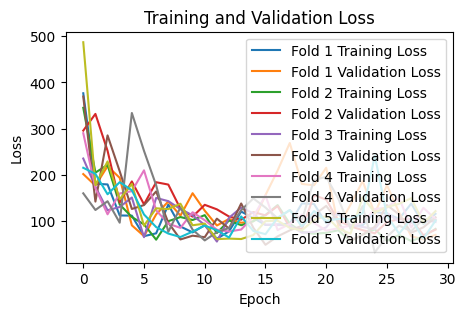

<Figure size 640x480 with 0 Axes>

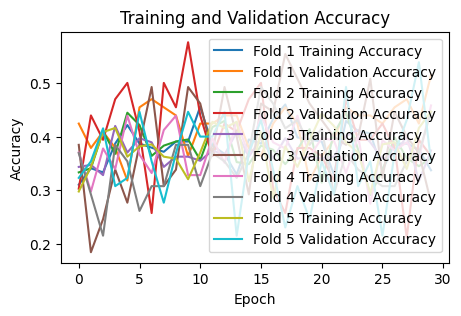

<Figure size 640x480 with 0 Axes>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import tensorflow as tf
from sklearn.model_selection import KFold
from matplotlib import pyplot as plt

class DataProcessor:
    def __init__(self, seed=42):
        self.seed = seed
        np.random.seed(seed)
        tf.random.set_seed(seed)

    # Load and preprocess data from a given path
    def load_and_preprocess_data(self, data_path):
        df = pd.read_csv(data_path)
        df['label'] = df['experiment'].apply(lambda x: x.split('_')[2])
        df.drop('experiment', axis=1, inplace=True)

        label_encoder = LabelEncoder()
        df["class"] = label_encoder.fit_transform(df["class"])
        df["encoded_label"] = label_encoder.fit_transform(df["label"])

        X = df.drop(["label", "encoded_label"], axis=1)
        y = df["encoded_label"]

        X_tensor = tf.convert_to_tensor(X.values, dtype=tf.float32)
        y_array = y.values

        return X_tensor, y_array, label_encoder

# Define a class for building and training the custom model
class CustomModel:
    def __init__(self, input_shape, num_classes):
        self.model = self.build_model(input_shape, num_classes)

    def scaled_dot_product_attention(self, q, k, v):
        matmul_qk = tf.matmul(q, k, transpose_b=True)
        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
        output = tf.matmul(attention_weights, v)
        return output, attention_weights

    def build_model(self, input_shape, num_classes):
        inputs = tf.keras.layers.Input(shape=input_shape)

        # Self-Attention Layer
        q = tf.keras.layers.Dense(64)(inputs)
        k = tf.keras.layers.Dense(64)(inputs)
        v = tf.keras.layers.Dense(64)(inputs)
        attention_output, _ = self.scaled_dot_product_attention(q, k, v)

        # Feed-Forward Layer
        attention_output = tf.keras.layers.Dense(64, activation='relu')(attention_output)

        # Output Layer
        output = tf.keras.layers.Dense(num_classes)(attention_output)

        model = tf.keras.Model(inputs=inputs, outputs=output)
        model.compile(optimizer='adam',
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                      metrics=['accuracy'])
        return model


# Define a function to train and evaluate the model
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    history = model.fit(X_train, y_train, epochs=30, verbose=1, validation_data=(X_test, y_test))
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    return history, test_accuracy

# Define a function to plot training and validation loss curves
def plot_loss_curves(history_list):
    plt.figure(figsize=(5, 3))
    for fold, history in enumerate(history_list):
        plt.plot(history.history['loss'], label=f"Fold {fold+1} Training Loss")
        plt.plot(history.history['val_loss'], label=f"Fold {fold+1} Validation Loss")
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    plt.savefig('loss.png')

# Define a function to plot training and validation accuracy curves
def plot_accuracy_curves(history_list):
    plt.figure(figsize=(5, 3))
    for fold, history in enumerate(history_list):
        plt.plot(history.history['accuracy'], label=f"Fold {fold+1} Training Accuracy")
        plt.plot(history.history['val_accuracy'], label=f"Fold {fold+1} Validation Accuracy")
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    plt.savefig('accuracy.png')

# Define the main function
def main():
    # Initialize the data processor
    data_processor = DataProcessor()

    # Load and preprocess data
    X, y, label_encoder = data_processor.load_and_preprocess_data("/content/combined_df.csv")

    num_folds = 5
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=data_processor.seed)

    test_accuracies = []
    history_list = []

    # Iterate through folds
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        print(f"Fold {fold + 1}/{num_folds}")

        X_train, X_test = tf.gather(X, train_index), tf.gather(X, test_index)
        y_train, y_test = y[train_index], y[test_index]

        # Create and compile the custom model
        model = CustomModel(input_shape=(305,), num_classes=len(label_encoder.classes_)).model

        # Train and evaluate the model
        history, test_accuracy = train_and_evaluate_model(model, X_train, y_train, X_test, y_test)
        history_list.append(history)
        test_accuracies.append(test_accuracy)

    # Convert encoded labels back to original string labels
    all_true_labels = label_encoder.inverse_transform(y_test)
    all_predicted_labels = label_encoder.inverse_transform(np.argmax(model.predict(X_test), axis=1))

    # Calculate and display classification report
    overall_classification_report = classification_report(all_true_labels, all_predicted_labels,
                                                          target_names=label_encoder.classes_)
    print("Overall Classification Report:\n", overall_classification_report)

    # Calculate and display average test accuracy
    average_test_accuracy = np.mean(test_accuracies)
    print("Average Test Accuracy:", average_test_accuracy)

    # Plot loss and accuracy curves
    plot_loss_curves(history_list)
    plot_accuracy_curves(history_list)


# Entry point of the script
if __name__ == "__main__":
    main()


#Brief Report

**Data Preprocessing:**

- Read the provided experimental data and concat them.
- Separate the data into features (Four_1, Four_2, Four_3, Four_4) and labels (Patient group: Control, AD, MCI).

**Label Encoding:**

- Create a label encoding dictionary for the patient groups (Control, AD, MCI) to numerical values (e.g., 0, 1, 2).
- Map the patient groups to their corresponding numerical labels.

**Architecture:**

- Input Layer: The neural network starts with an input layer. It has 305 input units, which matches the number of features in your dataset.
- Hidden Layer: The first hidden layer has 64 neurons (units) and uses the ReLU activation function. This layer processes the input data and learns relevant patterns.
- Output Layer: The output layer has as many neurons as there are unique encoded labels in your dataset. This layer does not use an activation function explicitly because the loss function used (Sparse Categorical Cross-Entropy) already performs the necessary activation for multi-class classification.

**Hyperparameters:**

- optimizer: The chosen optimization algorithm is 'adam'. Adam (short for Adaptive Moment Estimation) is a popular optimization algorithm that adapts the learning rate during training.
- loss: The loss function is set to 'SparseCategoricalCrossentropy'. This is appropriate for multi-class classification problems with integer-encoded labels.
- metrics: During training, the model is also tracking the 'accuracy' metric to monitor how well it's performing.
- epochs: The number of training epochs is set to 5. One epoch means the model has seen the entire training dataset once.
- batch_size: The code doesn't explicitly set a batch size, so it defaults to the default value used by TensorFlow.

Overall, this architecture is a feedforward neural network with one hidden layer.





